In [1]:
import torch
import torchvision
from torchvision import datasets,models,transforms
from torch import nn,optim
import numpy as np
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import cv2
import glob
from torch.utils.data import DataLoader
import random

In [2]:
#using the inception network
model = models.inception_v3(pretrained=True)

In [3]:
#Image augmentation for the train set
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(299),  #the inception network takes in 299*299 image size
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

#Image augmentation for the test set
valid_transform = transforms.Compose([transforms.Resize(299),    #the inception network takes in 299*299 image size
                                      transforms.CenterCrop(299), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

data_dir = r"D:\Data\Flower Classification\flower_data"         #the path for the data

#Load the images from their files
train_data = datasets.ImageFolder(data_dir+"/train",transform=train_transform)
valid_data = datasets.ImageFolder(data_dir+"/valid",transform=valid_transform)

train_loader = DataLoader(train_data,batch_size=16,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=16,shuffle=True)

In [4]:
def get_unique_data():
    each_label = []
    each_image = []
    for image,label in train_data:
        if label not in each_label:
            each_image.append(image)
            each_label.append(label)
    return each_image,each_label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]


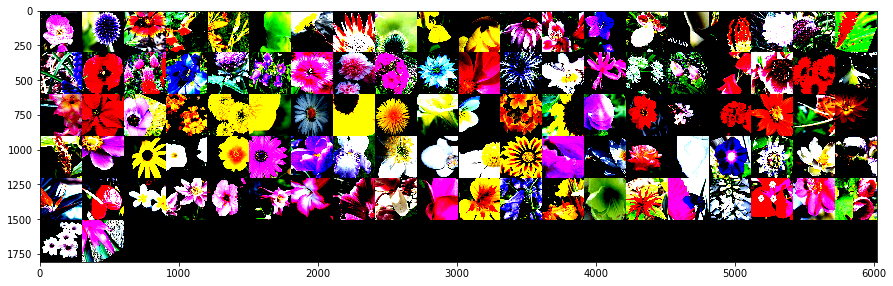

In [5]:
#printing all the classes
#ploting each type of flower we have
unique_images,unique_labels=get_unique_data()
grid=torchvision.utils.make_grid(unique_images,nrow=20, padding=2)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print('labels:',unique_labels)

In [3]:
#check whether we can use the gpu or not 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# updating all the parameters take much time but it improve the model's accuracy 
for param in model.parameters():
    param.requires_grad = True   
    
#connect the network with our fc layer
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features,102)
model.fc = nn.Linear(model.fc.in_features,102)  # 102 class we have in the dataset


critireon = nn.CrossEntropyLoss()   #the loss function crossentropy since its a classification problem
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)   # defining the optimizer 
model.to(device)

cuda:0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [7]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start = time.time()
    i=0
    best_model_wts = model.state_dict()
    best_acc = 0.0
    loss_over_time_train = []
    loss_over_time_valid = []
    acc_over_time_train = []
    acc_over_time_valid = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                dataloader=train_loader# Set model to training mode
            else:
                model.eval()
                dataloader=valid_loader# Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloader:
                # get the inputs
                inputs, labels = data

                inputs=inputs.to(device)
                labels=labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs,aux_outputs = model(inputs)
                        loss1 = criterion(outputs,labels)
                        loss2 = criterion(aux_outputs,labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # calculating the loss and accuracy
                running_loss  += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase=="train":
                epoch_loss = running_loss / len(train_data)
                loss_over_time_train.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_data)
                acc_over_time_train.append(epoch_acc)
    
                
            else:
                epoch_loss = running_loss / len(valid_data)
                loss_over_time_valid.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(valid_data)
                acc_over_time_valid.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts =model.state_dict()
            
        print('-' * 60)
                
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    loss = {"train":loss_over_time_train,"val":loss_over_time_valid}
    acc = {"train":acc_over_time_train,"val":acc_over_time_valid}
    return model,loss,acc

In [8]:
#training the model
num_epochs = 20
model_trained,loss,acc = train_model(model,critireon,optimizer,num_epochs)

Epoch 1/20
train Loss: 5.0087 Acc: 0.2434
valid Loss: 2.0503 Acc: 0.5685
------------------------------------------------------------
Epoch 2/20
train Loss: 2.6865 Acc: 0.5923
valid Loss: 0.8435 Acc: 0.8130
------------------------------------------------------------
Epoch 3/20
train Loss: 1.6097 Acc: 0.7668
valid Loss: 0.4380 Acc: 0.8998
------------------------------------------------------------
Epoch 4/20
train Loss: 1.0746 Acc: 0.8500
valid Loss: 0.2419 Acc: 0.9487
------------------------------------------------------------
Epoch 5/20
train Loss: 0.8430 Acc: 0.8768
valid Loss: 0.1832 Acc: 0.9597
------------------------------------------------------------
Epoch 6/20
train Loss: 0.6915 Acc: 0.9011
valid Loss: 0.1386 Acc: 0.9707
------------------------------------------------------------
Epoch 7/20
train Loss: 0.5880 Acc: 0.9135
valid Loss: 0.1398 Acc: 0.9584
------------------------------------------------------------
Epoch 8/20
train Loss: 0.5208 Acc: 0.9223
valid Loss: 0.1065 A

In [34]:
#the model's directory
model_dir = r"D:\Trained_models\Pytorch\Flower_Classification"
#the model's name
model_name = r"\flower_classification 2.pt"
#saving the best trained model
# torch.save(model.state_dict(),model_dir+model_name)

In [4]:
model.load_state_dict(torch.load(r"D:\Trained_models\Pytorch\Flower_Classification\flower_classification 2.pt"))
model.eval()         # converting the model to evaluate mode

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [5]:
import json
data=json.loads(open(r'D:\Data\Flower Classification\cat_to_name.json').read())    #loading flower names 

In [6]:
#preparing the test set to load
test_data = transforms.Compose([
        transforms.Resize(299),            #the inception's input size 299
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_data = datasets.ImageFolder(r"D:\Data\Flower Classification"+r"\test set",transform=test_data)
test_loader = DataLoader(test_data,batch_size=16,shuffle=False,num_workers=4)

In [7]:
#getting the name of the predicted class
def send_name(image_id):
    for im_id in data.keys():
        if im_id == str(image_id):
            name = data[im_id]
            return name

In [8]:
#storing every image name 
image_names = []
for i in test_loader.dataset.imgs:
    image_names.append(i[0].split('\\')[-1])

In [29]:
#predicting flower types 
output = []
flower_name = []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for i in predicted:
        flower_name.append(send_name(int(i)))
        output.append(int(i))

In [30]:
#using pandas dataframe to show the predictions
df = pd.DataFrame()
df['image_name'] = image_names
df['class'] = output
df['flower_name'] = flower_name

In [31]:
#displaying the predictios
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df)

    image_name  class                flower_name
0      aa1.jpg     60         pink-yellow dahlia
1     aa10.jpg     70                 tree poppy
2     aa11.jpg     71                    gazania
3     aa12.jpg     28           stemless gentian
4     aa13.jpg     73                 water lily
5     aa14.jpg     74                       rose
6     aa15.jpg      8           bird of paradise
7     aa16.jpg     51                    petunia
8     aa17.jpg     77             passion flower
9     aa18.jpg     73                 water lily
10    aa19.jpg     79                  toad lily
11     aa2.jpg     61           cautleya spicata
12    aa20.jpg     81                 frangipani
13     aa3.jpg     62           japanese anemone
14     aa4.jpg     63           black-eyed susan
15     aa5.jpg     64                 silverbush
16     aa6.jpg     26                 corn poppy
17     aa7.jpg     66               osteospermum
18     aa8.jpg     20      giant white arum lily
19     aa9.jpg     3

205   nic9.jpg     89                 watercress
